# Data Visualization <a class="tocSkip">
Author: Stefan Roland Schwingenschlögl <br>
email: stefan.roland.schwingenschloegl@gmail.com <br>
github: github.com/stefan-schwingenschloegl <br>
___
*Projekt File No: 5 <br>*
    
After collecting data for the stations in the last file 'API_extraction.ipynb', this notebook analyses the data to answer the question. As a reminder, the question was at which of the stations considered the least deviations of public transport from the planned departure time occurred. For this purpose, the data is extracted from the database and cleaned and processed using pandas. Afterwards, the data is visualised using seaborn and matplotlib. In the last part, the research question is answered and the limitations are mentioned. In addition, further steps for extensions are shown.

# Set General Properties

In [1]:
import numpy as np
import pandas as pd

import pyodbc

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set the path to the Wiener Linien API documentation
wl_docu_url = 'http://www.wienerlinien.at/ogd_realtime/doku/'

# set the URL to the Wiener Linien API real time monitor
wl_monitor_url = 'http://www.wienerlinien.at/ogd_realtime/monitor?'

# set consistens figure dimensions
fig_dim = (10, 5)

# hexadecimal colorcode palette from the Wiener Linien logo
wl_col = ['#e3010f', '#240b4c', '#f8ecec', '#db7778', '#ce5155', '#be919e', '#7c8494']
wl_palette = sns.color_palette(wl_col)

# set plot style
plt.style.use('ggplot')

# set properties for database
db_name = 'WienerLinienDB'
server = 'DESKTOP-JV1HTQR\SQLEXPRESS'
db_connection = False

# Initialize general methods for Database Connection

In [3]:
# establish DB Connection
def db_connect(server, db_name):
    """
    Establish database connection
    
    input args: server, db_name as string format
    return args: database connection object
    """
    conn = pyodbc.connect("driver={SQL Server};server="+server+"; database="+db_name+"; trusted_connection=true")
    db_connection = True
   # print(f"\nConnection with {server} sucessfull!\n"
    #      f"Current Database: {db_name}\n"
    #      f"DB Connection Status: {db_connection}")
    return conn

In [4]:
# close DB Connection
def close_connection(server, conn):
    conn.close()
    db_connection = False
   # print(f"\nDB-Connection with Server {server} closed.\n"
   #       f"DB Connections Status: {db_connection}")

# Extract all entries from Database

In [5]:
# method for extract all entries from the database
def get_stage_delay():
    conn = db_connect(server, db_name)
    with conn:
        df = pd.read_sql(f"select * from stage_delay order by timestamp desc", conn)
    
    close_connection(server, conn)
    
    return df

In [6]:
# extract data and save it into a pandas Dataframe
df = get_stage_delay()

# Data Preprocessing and Exploration
In this step, the data is analysed in principle and the data quality is assessed. Possible unrealistic values are edited or deleted.
##  Basic Data Exploration

In [7]:
df.shape

(14342, 12)

In [8]:
df.dtypes

timestamp       object
stop_name       object
line_name       object
lineID          object
towards         object
richtungsID     object
type            object
timePlanned     object
timeReal        object
DIVA             int64
rbl              int64
delay          float64
dtype: object

It can be seen that there are a total of 14432 lines which have 12 attributes. Additionally only `DIVA`, `rbl` and `delay` are numeric values. `timestamp`, `timeReal` and `timePlanned` should be a datetime type, `lineID` and `richtungsID` can be interpreted as integer while everything else should be the type `category`. In the next step this the columns will be adjusted.

The values for missing `timestamp`, `timeReal` and `timePlanned` were set inside the `fill_na`-method in the `API_Extraction.ipynb` to **9999-12-31 23:59:59+01:00**. Now these values should be casted from type object to datetime with the pandas `to_datetime`-method. However the big value is to high for this data type. After searching for possible reasons why there is a *Out-of-Bounds-Error* I read in the [docs](http://pandas-docs.github.io/pandas-docs-travis/user_guide/timeseries.html#timeseries-timestamp-limits) that the date is too big. Therefore all of these big values will be set to `Not-A-Date` values. This will be done with the `errors = 'coerce'` argument.

In [9]:
# cast all string columns to category and all numeric columns to int, besides datetime and float types
def cast_columns(df):
    print(f'Types before: \n{df.dtypes}\n')
    for col in df.columns:
        if 'time' in col:
            df[col] = pd.to_datetime(df[col], errors = 'coerce')
            continue
        elif df[col].dtypes == 'float64':
            continue
        try: 
            df[col] = df[col].astype('int64')
        except ValueError:
            df[col] = df[col].astype('category')
    print(f'Types afterwards: \n{df.dtypes}')
    return df

df = cast_columns(df)

Types before: 
timestamp       object
stop_name       object
line_name       object
lineID          object
towards         object
richtungsID     object
type            object
timePlanned     object
timeReal        object
DIVA             int64
rbl              int64
delay          float64
dtype: object

Types afterwards: 
timestamp      datetime64[ns]
stop_name            category
line_name            category
lineID                  int64
towards              category
richtungsID             int64
type                 category
timePlanned    datetime64[ns]
timeReal       datetime64[ns]
DIVA                    int64
rbl                     int64
delay                 float64
dtype: object


It can be seen that all of this categories got converted sucessfully. Now it is time to look a little more closely at the information in the data.

## Data Cleaning
In this section the data will be checked and cleaned. First, the missing values are considered. Then it is checked whether a certain means of transport frequently delivers unusual values.

### Process missing Values

                timestamp            stop_name line_name  lineID  \
30    2021-02-02 21:58:00  Kardinal-Nagl-Platz        U3     303   
285   2021-02-02 21:43:00  Kardinal-Nagl-Platz        U3     303   
457   2021-02-02 21:33:00           Schönbrunn        U4     304   
540   2021-02-02 21:27:59  Kardinal-Nagl-Platz        U3     303   
778   2021-02-02 21:13:59  Kardinal-Nagl-Platz        U3     303   
967   2021-02-02 21:02:59           Schönbrunn        U4     304   
1169  2021-02-02 20:50:59  Kardinal-Nagl-Platz        U3     303   
1424  2021-02-02 20:35:00  Kardinal-Nagl-Platz        U3     303   
3221  2021-02-02 18:51:59           Schönbrunn        U4     304   
3239  2021-02-02 18:51:00           Schönbrunn        U4     304   
3452  2021-02-02 18:39:00  Kardinal-Nagl-Platz        U3     303   
5973  2021-02-02 16:13:59  Kardinal-Nagl-Platz        U3     303   
9424  2021-02-02 12:55:59  Kardinal-Nagl-Platz        U3     303   
10973 2021-02-02 11:24:00  Kardinal-Nagl-Platz  

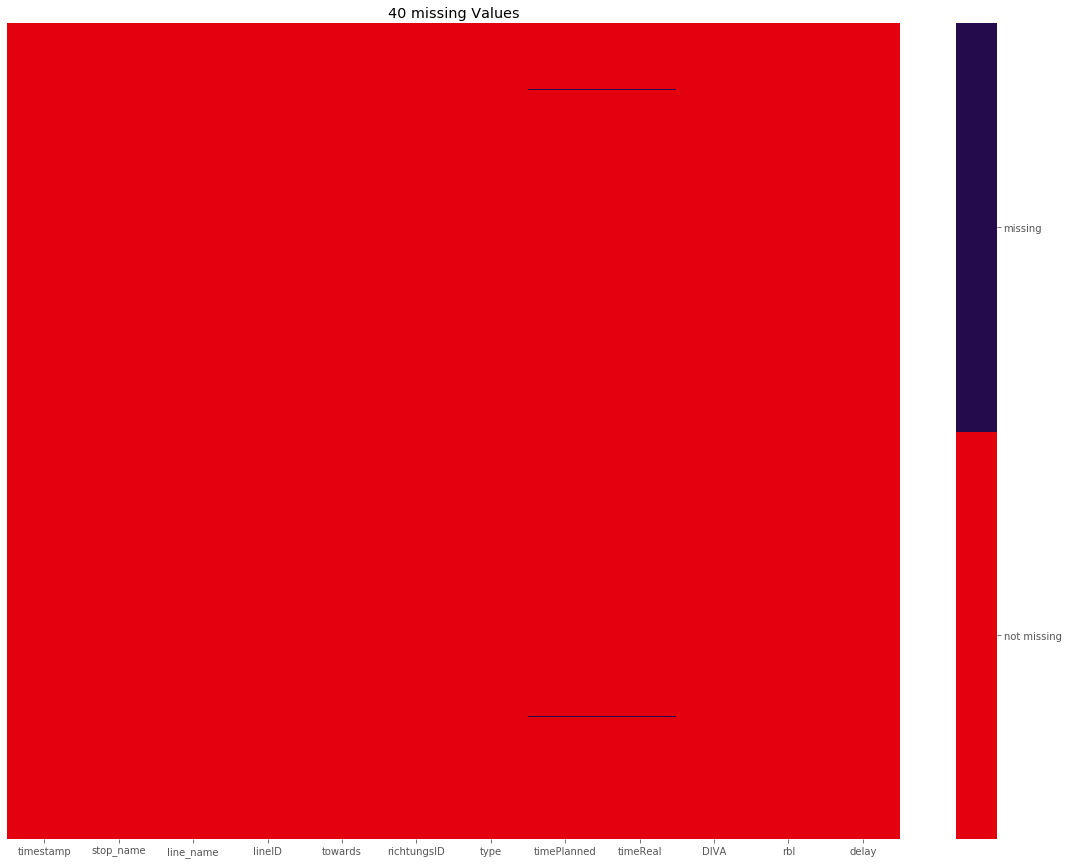

In [10]:
def get_amount_of_na(df):
    amount = df.isna().sum().sum().astype(str)
    return amount

def visualize_na(df, fig_dim):
    missing_values = get_amount_of_na(df)
        
    plt.figure(figsize = (20, 15))
    ax = sns.heatmap(df.isna(),
            yticklabels=False,
            vmin=0,
            vmax=1,
            cmap=wl_palette[:2],
            cbar=True)
    ax.set_title(f'{missing_values} missing Values')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0.25, 0.75])
    cbar.set_ticklabels(['not missing', 'missing'])
    
    if int(missing_values) > 0:
        print(df[df.isnull().any(axis=1)])
    

visualize_na(df, fig_dim)  

So there are 16 mising values in the dataset. Due to the fact that singely rows are to small this is not visible in the graphics. It can be seen that only a few entries are not valid. Most of the entries have no missing values in it. 

All of the missing values are Metros and it seems that they are special trains. It is not possible to board this trains for public persons. Therefore I will remove the missing values.

In [11]:
# drop all rows with missing values in it
df = df.dropna()

### Inspect delay by type of transport

In [12]:
def validate_input(x, y):
    if x not in df.columns or y not in df.columns:
        raise ValueError('At least one of your input arguments is not in the columns of the dataframe. Please check!')

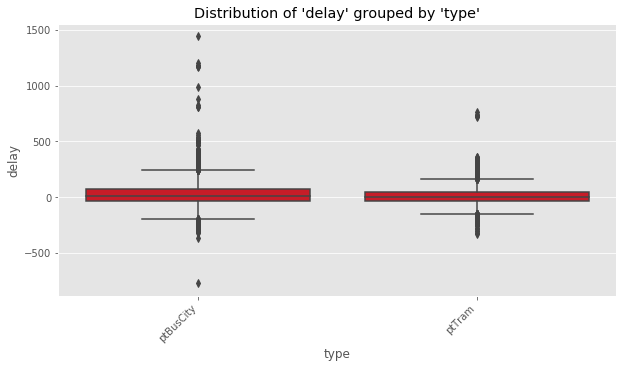

In [46]:
def plot_boxplot(df, x, y, fig_dim = (10,5)):
    validate_input(x,y)
        
    plt.figure(figsize = fig_dim)
    ax = sns.boxplot(x=x,
                     y=y,
                     data=df,
                     color = wl_palette[0])
    ax.set_title(f"Distribution of '{y}' grouped by '{x}'")
    ax.set_xticklabels(ax.get_xticklabels(), 
                          rotation=45,
                          ha='right')
    

plot_boxplot(df,'type', 'delay', fig_dim)

In [14]:
df[['type','delay']].groupby('type').describe()

delay                                                       
            count       mean         std    min   25%  50%   75%     max
type                                                                    
ptBusCity  7882.0  28.755392  105.867247 -770.0 -30.0  9.0  78.0  1441.0
ptMetro    3176.0   0.000000    0.000000    0.0   0.0  0.0   0.0     0.0
ptTram     3264.0  14.034007   91.796139 -325.0 -30.0  0.0  48.0   761.0

It can be seen that there is no dispersion in the delays of the metro. Upon further investigation, it can be seen that not a single metro was even a single second late or early. From my own experience I can say that this is not really realistic ;-) <br>
Overall, no delays were indicated despite the Real Time Support displayed. Therefore, entries coming from an metro cannot be taken into account. Therefore, only buses and trams can be evaluated. This reduces the data stock considerably. Consequently, only buses and trams can be analysed. This is a clear limitation in the statement of the entire analysis, as for me the metro is usually the preferred means of transport.The remaining values look realistic and will be kept.

In [15]:
df = df.loc[df['type'] != 'ptMetro']
df['type'].cat.remove_unused_categories(inplace=True)

In [16]:
df[['type','delay']].groupby('type').describe()

delay                                                       
            count       mean         std    min   25%  50%   75%     max
type                                                                    
ptBusCity  7882.0  28.755392  105.867247 -770.0 -30.0  9.0  78.0  1441.0
ptTram     3264.0  14.034007   91.796139 -325.0 -30.0  0.0  48.0   761.0

### Number of entries by stopname
In the next step, the number of entries per station is displayed. The human-readable column 'stop_names' is used for this. 

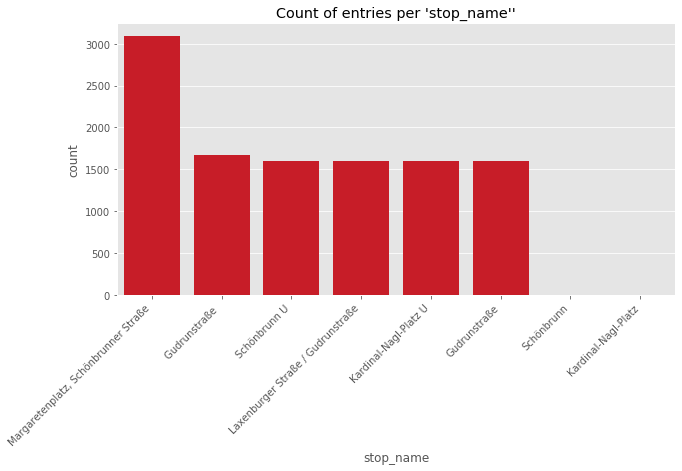

In [20]:
def val_count(df, col, hue=None):
    if col not in df.columns:
        raise ValueError('At least one of your input arguments is not in the columns of the dataframe. Please check!')
        
    plt.figure(figsize = fig_dim)
    ax = sns.countplot(x=col,
                       data=df,
                       color=wl_palette[0],
                       order=df[col].value_counts().index,
                       hue=hue)
    
    ax.set_title(f"Count of entries per '{col}''")
    ax.set_xticklabels(ax.get_xticklabels(), 
                          rotation=45,
                          ha='right')
    
val_count(df, 'stop_name')

Here you can see that the two stations 'Schönbrunn' and 'Kardinal-Nagl-Platz' probably only provided entries that were used by underground trains. Therefore, these two stop_names can also be dropped in this analysis. <br>
It is also interesting that there are probably two entries with the name 'Gudrunstraße'. In the next step, it would be interesting to see what the difference is. It is also interesting that 'Laxenburger Straße/Gudrunstraße' is listed separately. These three stop_names will be given attention in the next step.
___

#### Stops which contain 'Gudrunstraße' in their 'stop_name'

In [21]:
# get DIVA name of all stops which contains 'Gudrunstraße'
df.loc[df['stop_name'].str.contains('Gudrunstraße'), 'DIVA'].unique()

array([60200136], dtype=int64)

In [88]:
# all lines which stop at 'Laxenburger Straße / Gudrunstraße'
df.loc[df['stop_name'] == 'Laxenburger Straße / Gudrunstraße', 'line_name'].unique()

[14A]
Categories (1, object): [14A]

In [23]:
# all lines which stop at 'Gudrunstraße'
df.loc[df['stop_name'] == 'Gudrunstraße', ['line_name', 'towards']]

,line_name,towards
6,18,Schlachthausgasse U
11,O,Bruno-Marek-Allee
23,18,Schlachthausgasse U
28,O,Bruno-Marek-Allee
40,18,Schlachthausgasse U
...,...,...
14300,O,Bruno-Marek-Allee
14313,18,Schlachthausgasse U
14318,O,Bruno-Marek-Allee
14331,18,Schlachthausgasse U


In [90]:
# all lines which stop at 'Gudrunstraße'
df.loc[df['stop_name'] == 'Gudrunstraße ', ['line_name', 'towards']]

,line_name,towards
8,18,Quellenplatz
13,O,"Raxstraße, Rudolfshügelgasse"
26,18,Quellenplatz
31,O,"Raxstraße, Rudolfshügelgasse"
44,18,Quellenplatz
...,...,...
8127,O,"Raxstraße, Rudolfshügelgasse"
8140,18,Quellenplatz
8145,O,"Raxstraße, Rudolfshügelgasse"
8158,18,Quellenplatz


It can now be seen that at 'Laxenburger Straße / Gudrunstraße' only line '14A' stops in both directions. At 'Gudrunstraße' only line 'O' runs in the direction of 'Bruno-Marek-Alle'. For the route in the other direction, there must have been a typing error. This name is 'Gudrunstraße ' and at this one the line 'O' goes in the direction of 'Raxstraße, Rudolfshügelgasse' and the '18' runs towards 'Quellenplatz'. Since everything leaves at the same DIVA, the name is changed for all to 'Gudrunstraße'.

In [24]:
 df['stop_name'] = df['stop_name'].replace(dict.fromkeys(['Gudrunstraße ','Laxenburger Straße / Gudrunstraße'], 'Gudrunstraße'))

### Reduce dataframe to get only last Entry per planned depature
With the workflow, the current delay of the next vehicle was queried once per minute. If a vehicle now has an extremely long delay, this vehicle would very often be counted as a delay. To prevent this, only the last entry of each vehicle before the next one arrives is retained in the data. This is done by grouping by 'timePlanned', 'stop_name', 'line_name', 'directionID' and keeping only the last entry. This reduces the dataset to $\sim \frac{1}{6}$ of the respective output set.

In [27]:
df_red = df.groupby(['timePlanned', 'stop_name', 'line_name', 'richtungsID']).tail(1)

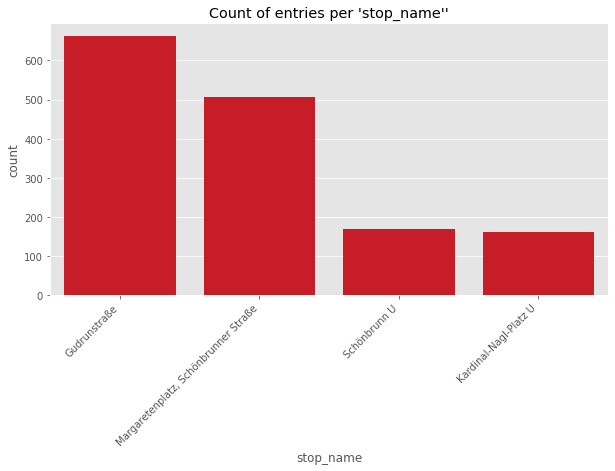

In [28]:
val_count(df_red, 'stop_name')

## Data Exploration
___
### General delay per station
The initial question to be clarified was which station has the least delays. This will now be clarified in the course of this section. For this purpose, the different stations are grouped and the distribution is evaluated for each station by means of numerical values, as well as graphically represented with a boxplot. A first conclusion is drawn here to answer the question.

,count,mean,std,min,25%,50%,75%,max
stop_name,,,,,,,,
Gudrunstraße,662.0,1.164653,73.854654,-286.0,-27.0,0.0,11.75,728.0
Kardinal-Nagl-Platz U,162.0,45.277778,65.963123,-55.0,0.0,5.5,78.00,297.0
"Margaretenplatz, Schönbrunner Straße",506.0,4.357708,87.067360,-770.0,-46.0,5.5,44.00,499.0
Schönbrunn U,169.0,-4.360947,71.867561,-234.0,-38.0,0.0,5.00,284.0


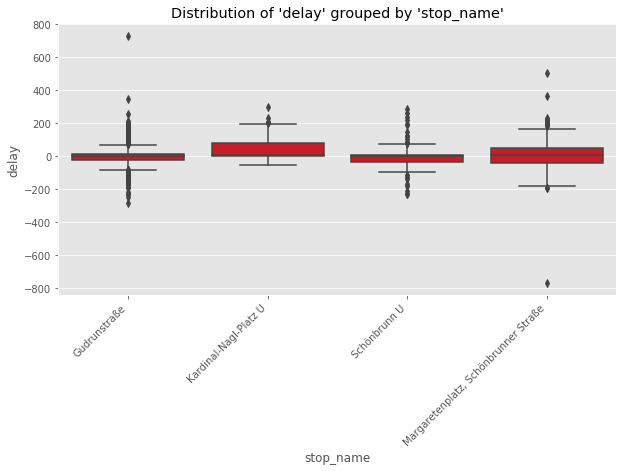

In [47]:
# get statistics of delays per stop_name
plot_boxplot(df_red, 'stop_name', 'delay')
df_red.groupby('stop_name')['delay'].describe()

Here it can be seen that the delays at the respective stops do differ somewhat. In the median, the stop 'Gudrunstraße' and the stop 'Schönbrunn' both have the smallest deviation from the planned time with 0 seconds.  These are followed by 'Kardinal-Nagl-Platz U' and 'Margaretenplatz, Schönbrunner Straße' with 5.5 seconds. This is not a big gap in between.  <br>
However, if you look at the mean value, you see very big differences. Here, the station 'Gudrunstraße' is also the best with an average deviation of approx. 1 second. Margaretenplatz, Schönbrunner Straße' comes second with an average delay of about 4.4 seconds. It is interesting that at 'Schönbrunn' the means of transport arrive approx. 4.4 seconds early. In last place is 'Kardinal-Nagl-Platz' with a delay of about 45 seconds. However, this has the lowest standard deviation. This amounts to 66 seconds. Schönbrunn' and 'Gudrunstraße' are very close to each other with 72 and 74 seconds respectively. Margartenplatz, Schönbrunner Straße' has the highest dispersion with 87 seconds. <br>
In addition, it should be said that the span is smallest at 'Kardinal-Nagl-Platz'. This is in the interval [-55; 297]. For 'Schönbrunn' it is second best, namely [-234; 284].
This is followed by the stations 'Gudrunstraße' and 'Margaretenplatz, Schönbrunner Straße' with [-286; 728] and [-770; 499].


# Discussion

Based on the data, it is hard to say which station is really **the** best. In terms of delay, I would say that 'Gudrunstraße' shows the least deviation in both median and mean. However, there are a lot of outliers here. This means that, on average, you wait a very short time for the next means of transport, but you can often be unlucky and have to wait a very long time. 
Here I would say that 'Cardinal Nagl Square' has the lowest standard deviation. However, this is where you wait the longest on average. <br>
In my opinion, the best trade-off is 'Schönbrunn'. Here the range is moderate, the mean value only deviates by a few seconds and there is no delay at all in the median. The Qaurtiel values are also very good in comparison. I would say that 'Schönbrunn' delivers the best values in this respect. <br>
I would rank 'Gudrunstraße' in second place. The quartile values here are quite okay, especially up to the 75% quartile. However, you should be aware that a means of transport often arrives too soon and you should plan a little more time and arrive earlier at the station. <br>
In third place I see 'Kardinal-Nagl-Platz' Here it is rather the case that one should not expect early departure times, but rather a tendency towards somewhat late ones. However, the delays are moderate and there are no glaring outliers. So this could be seen as a relatively reliable option. <br>
In last place I rank 'Margaretenplatz, Schönrunner Straße'. This has a very small average deviation, but the standard deviation is huge. No real trend can be identified as to whether the means of transport arrive too early or too late, so you have to reckon with everything. <br>

## Limitations

The data was only collected for one day and there were even exit restrictions on that day. To see a real trend, this analysis would have to provide multiple dates and the period of observation would have to be longer. <br>
In addition, no distinction was made as to where each mode of transport was going. The delays were only analysed in aggregated form. All were treated equally. However, a weighting would make sense here, as I tend to use journeys into the city centre or to railway stations more often than out of the city. <br>
In addition, no statement could be made about how much delay the metro has. However, this is a very important factor for me. I prefer underground journeys because they are quick and uncomplicated. This in particular would add value to 'Schönbrunn' and 'Kardinal-Nagl-Platz'.

## Further Work

As future tasks, I could imagine creating a dashboard of the next station with real-time data and evaluating when the next means of transport will arrive. <br>
In the analysis, it would certainly be interesting to distinguish more precisely between the individual lines and to see whether individual lines are particularly susceptible to delays or early arrivals. <br>
In addition, it would be interesting to evaluate the delays over the course of the day. Here it could be interesting to see whether a station is particularly affected by morning or evening traffic.  <br>
As a last point, it would be interesting to intersect the delay data with other real-time data. At first glance, weather information or information about the traffic flow would come to mind. It would be interesting to see if there are any correlations.


# Personal Reflection

My main focus was to train my data cleaning skills with real world data. I did this by cleaning the static files and the collected real-time data. <br>
Furthermore, I wanted to learn how to integrate a database into a Python script and write data about it into the database. I have achieved this as well. <br>
Lastly, I wanted to learn to work with an API and retrieve data automatically. Here, too, I am very satisfied, as I had no prior experience in working with APIs. <br>

Things that are not yet optimal are, for example, the function that retrieves the data. It works, but I don't think it's really elegant yet.  Personally, I still see a lot of potential for improvement here in terms of clean programming. <br>
In addition, the analysis is still expandable. A lot more could be extracted from the data here. However, since the focus was more on the technical implementation in the backend, I am basically satisfied with the extent of the analysis.<br>

All in all, however, I am very satisfied with the project. I have learned a lot of new things here, which is the most important thing for me personally.
